In [ ]:
pip install pydicom


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.9 MB/s eta 0:00:00


In [ ]:
pip install nibabel

In [ ]:
knee_images_folder = "JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Knee/Images"
knee_annotations_folder = "JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Knee/Annotations"

Number of DICOM images: 616
Number of annotation files: 616


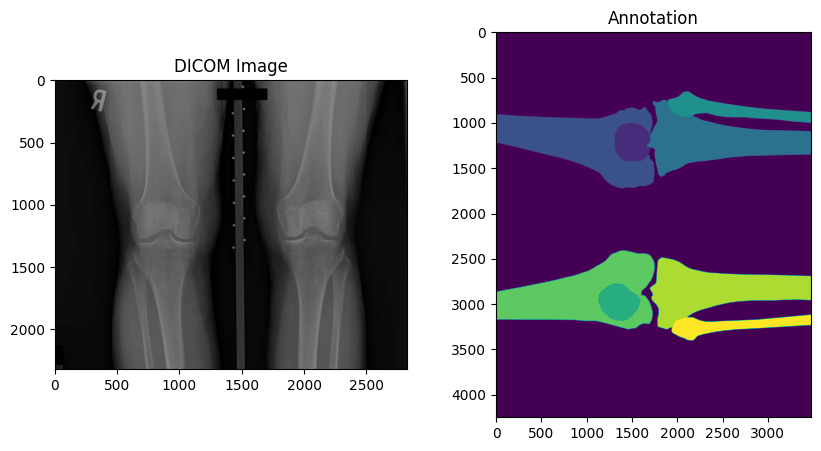

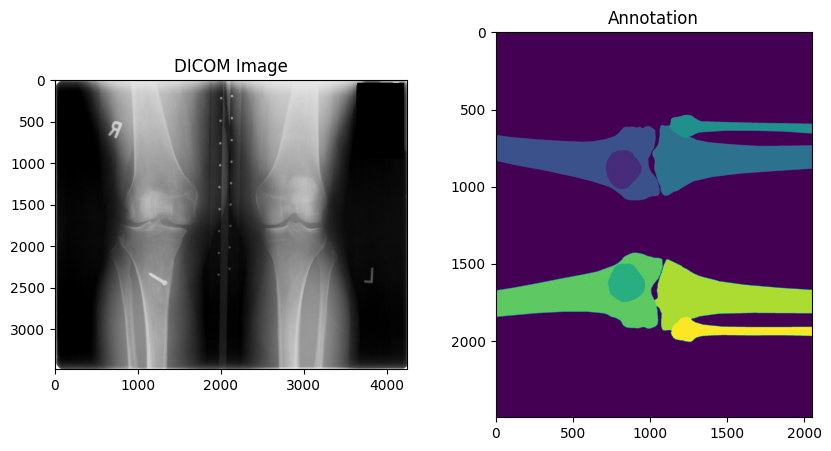

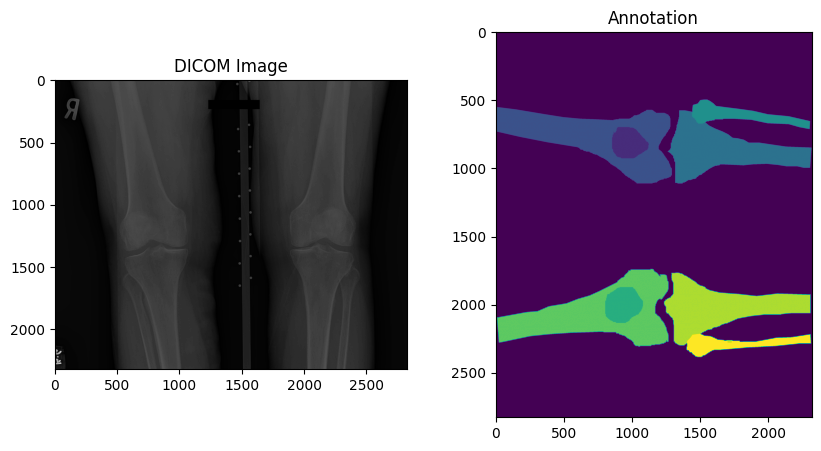

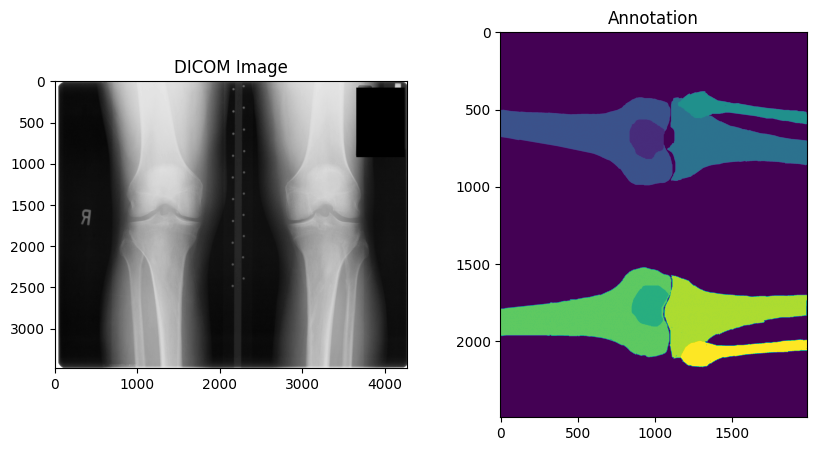

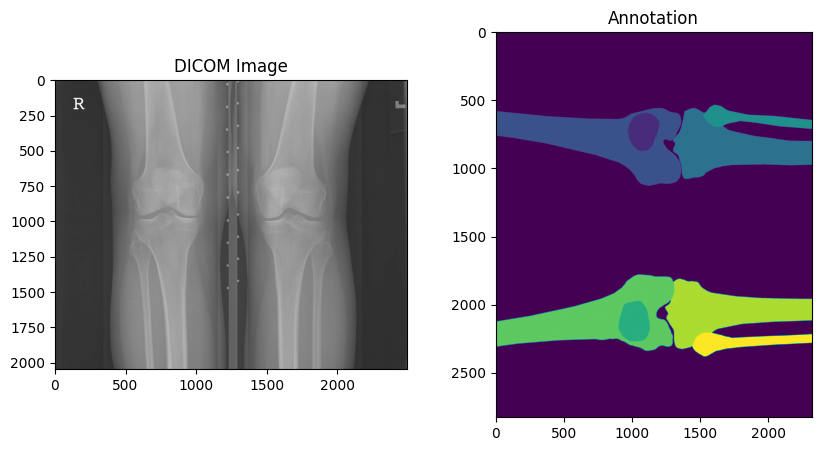

In [ ]:
import os
import pydicom
import nibabel as nib
import matplotlib.pyplot as plt

def load_and_visualize_data(images_folder, annotations_folder):
    # Load DICOM images
    image_files = [file for file in os.listdir(images_folder) if file.endswith(".dcm")]
    annotation_files = [file for file in os.listdir(annotations_folder) if file.endswith(".nii.gz")]

    # Display the number of images and annotations
    print(f"Number of DICOM images: {len(image_files)}")
    print(f"Number of annotation files: {len(annotation_files)}")

    # Visualize a few samples
    for i in range(min(5, len(image_files))):
        image_path = os.path.join(images_folder, image_files[i])
        annotation_path = os.path.join(annotations_folder, annotation_files[i])

        # Load DICOM image
        dicom_image = pydicom.dcmread(image_path)
        image_array = dicom_image.pixel_array

        # Load annotation
        annotation = nib.load(annotation_path).get_fdata()

        # Plot the image and annotation side by side
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(image_array, cmap='gray')
        plt.title("DICOM Image")

        plt.subplot(1, 2, 2)
        plt.imshow(annotation, cmap='viridis')
        plt.title("Annotation")

        plt.show()

# Explore hip dataset
load_and_visualize_data(knee_images_folder, knee_annotations_folder)


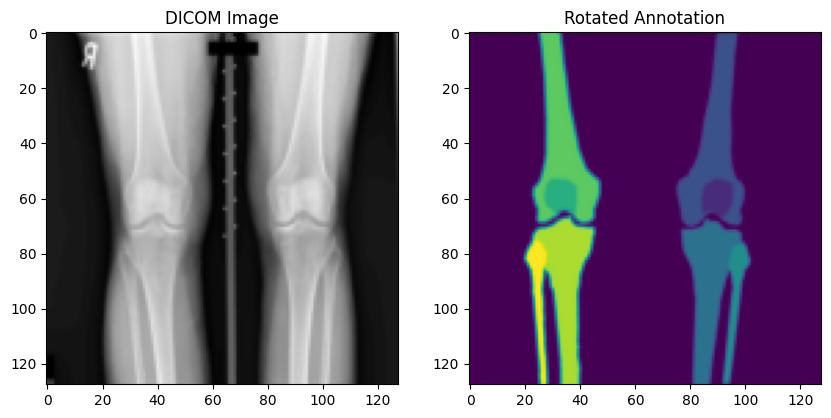

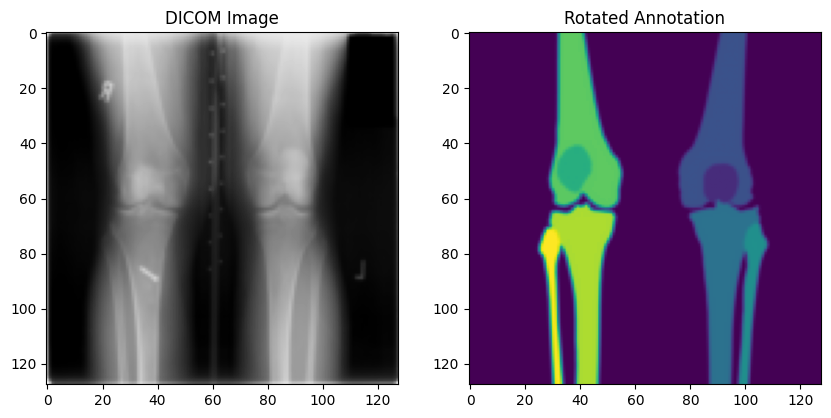

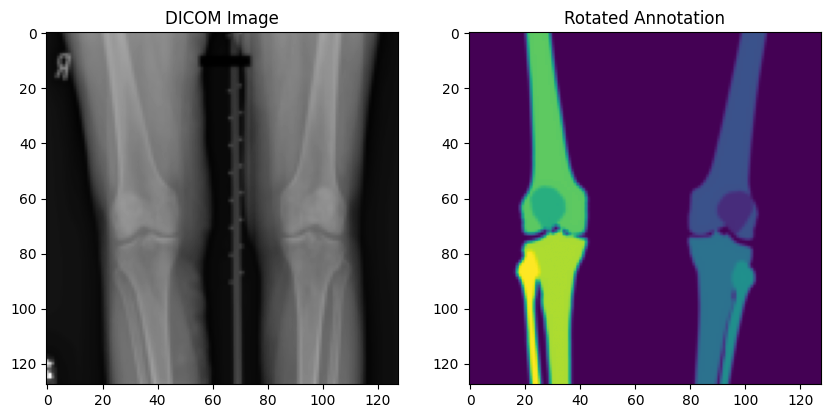

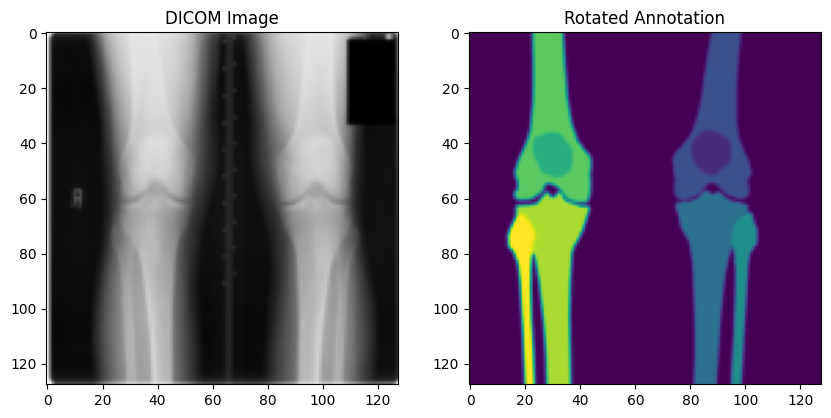

Epoch 1/15
3/3 [==============================] - ETA: 0s - loss: 0.4732 - iou_metric: 0.5268 - f1_score: 0.6823 
Epoch 1: val_loss improved from inf to 0.48149, saving model to knee_Model_with_ResNet_Backbone_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 128s 37s/step - loss: 0.4732 - iou_metric: 0.5268 - f1_score: 0.6823 - val_loss: 0.4815 - val_iou_metric: 0.5185 - val_f1_score: 0.4092
Epoch 2/15
3/3 [==============================] - ETA: 0s - loss: 0.4293 - iou_metric: 0.5707 - f1_score: 0.6550 
Epoch 2: val_loss improved from 0.48149 to 0.48014, saving model to knee_Model_with_ResNet_Backbone_best.h5
3/3 [==============================] - 91s 35s/step - loss: 0.4293 - iou_metric: 0.5707 - f1_score: 0.6550 - val_loss: 0.4801 - val_iou_metric: 0.5199 - val_f1_score: 0.4065
Epoch 3/15
3/3 [==============================] - ETA: 0s - loss: 0.3916 - iou_metric: 0.6084 - f1_score: 0.6026 
Epoch 3: val_loss improved from 0.48014 to 0.47791, saving model to knee_Model_with_ResNet_Backbone_best.h5
3/3 [==============================] - 88s 31s/step - loss: 0.3916 - iou_metric: 0.6084 - f1_score: 0.6026 - val_loss: 0.4779 - val_iou_metric: 0.5221 - val_f1_score: 0.4053
Epoch 4/15
3/3 [=================

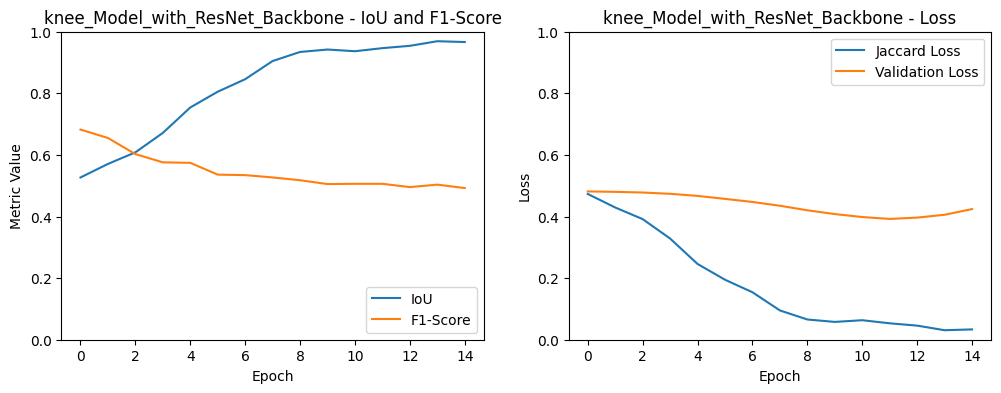

In [ ]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU, Precision, Recall
from skimage.transform import resize
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import ModelCheckpoint

# Jaccard Loss (IoU Loss)
def jaccard_loss(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=(-3, -2, -1))
    union = K.sum(K.abs(y_true) + K.abs(y_pred), axis=(-3, -2, -1)) - intersection
    jaccard = K.clip((intersection + 1e-7) / (union + 1e-7), 0, 1)  # Clip to [0, 1] range
    return 1 - jaccard  # Return 1 - Jaccard for loss

#IoU Metric
def iou_metric(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=(-3, -2, -1))
    union = K.sum(K.abs(y_true) + K.abs(y_pred), axis=(-3, -2, -1)) - intersection
    iou = K.clip((intersection + 1e-7) / (union + 1e-7), 0, 1)  # Clip to [0, 1] range
    return iou

#the F1-score metric
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Clip the F1 score to ensure it's within [0, 1]
    f1 = K.clip(f1, 0, 1)

    return f1


# Set the paths
knee_images_folder = "JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Knee/Images"
knee_annotations_folder = "JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Knee/Annotations"

# Parameters
img_height, img_width = 128, 128  # Adjusted to (128, 128)
num_samples = 250
batch_size = 32

def rotate_left_90_degrees(annotation):
    return np.rot90(annotation, k=3)  # Rotate left by 90 degrees

def load_dicom_image(path):
    dicom = pydicom.dcmread(path)
    image = apply_voi_lut(dicom.pixel_array, dicom)
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        image = np.amax(image) - image
    image = image - np.min(image)
    if np.max(image) != 0:
        image = image / np.max(image)
    return image

def load_data(images_folder, annotations_folder, num_samples):
    images = []
    masks = []

    image_files = sorted(os.listdir(images_folder))[:num_samples]
    annotation_files = sorted(os.listdir(annotations_folder))[:num_samples]

    for img_file, ann_file in zip(image_files, annotation_files):
        img_path = os.path.join(images_folder, img_file)
        img = load_dicom_image(img_path)
        img = resize(img, (img_height, img_width), preserve_range=True, anti_aliasing=True)
        img = np.expand_dims(img, axis=-1)  # Ensure the image is 3D with shape (height, width, channels)

        ann_path = os.path.join(annotations_folder, ann_file)
        ann_img = nib.load(ann_path).get_fdata()
        ann_img = rotate_left_90_degrees(ann_img)  # Rotate annotation left by 90 degrees
        ann_img = resize(ann_img, (img_height, img_width), preserve_range=True, anti_aliasing=True)
        if len(ann_img.shape) == 2:
            ann_img = np.expand_dims(ann_img, axis=-1)

        # Check if the shapes are consistent
        if img.shape != (img_height, img_width, 1) or ann_img.shape != (img_height, img_width, 1):
            print(f"Skipping {img_file} and {ann_file} due to inconsistent shapes: {img.shape}, {ann_img.shape}")
            continue  # Skip this pair of image and mask

        images.append(img)
        masks.append(ann_img)

    # Convert lists to numpy arrays
    images = np.stack(images, axis=0)
    masks = np.stack(masks, axis=0)

    return images, masks

# Load data
images, masks = load_data(knee_images_folder, knee_annotations_folder, num_samples)

# Plot 3 to 4 samples
num_samples_to_plot = min(4, num_samples)
for i in range(num_samples_to_plot):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title("DICOM Image")

    plt.subplot(1, 2, 2)
    plt.imshow(masks[i].squeeze(), cmap='viridis')
    plt.title("Rotated Annotation")

    plt.show()

#model architecture with Batch Normalization
def create_unet_resnet_model(input_size=(128, 128, 1)):
    # Load ResNet50 as the backbone
    base_model = ResNet50(input_shape=input_size, include_top=False, weights=None)

    # Decoder part of the U-Net
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(base_model.output)
    x = concatenate([x, base_model.get_layer('conv4_block6_out').output])
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Add Batch Normalization

    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, base_model.get_layer('conv3_block4_out').output])
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Add Batch Normalization

    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, base_model.get_layer('conv2_block3_out').output])
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Add Batch Normalization

    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, base_model.get_layer('conv1_relu').output])
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Add Batch Normalization

    # Output layer
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)

    # Resize the output to match the input size
    x = Lambda(lambda image: tf.image.resize(image, (img_height, img_width)))(x)

    return Model(inputs=base_model.input, outputs=x)

# Train and evaluate the model with Jaccard loss, IoU metric, and F1-score metric
def train_and_evaluate_model(images, masks, model_name, batch_size):
    # Data augmentation
    data_gen_args = dict(
        rotation_range=90,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    mask_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

    # Normalize images
    images = images / 255.0

    # Split the data into training, validation, and test sets
    train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.25, random_state=42)
    train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=1/3, random_state=42)

    # Calculate steps_per_epoch based on batch size
    steps_per_epoch = len(train_images) // batch_size

    # data generators
    image_generator = image_data_generator.flow(train_images, batch_size=batch_size)
    mask_generator = mask_data_generator.flow(train_masks, batch_size=batch_size)

    # Combine generators to get the augmented training data
    train_generator = zip(image_generator, mask_generator)

    # Get the model
    model = create_unet_resnet_model()

    # Define a ModelCheckpoint callback to save the best model
    checkpoint_callback = ModelCheckpoint(
        filepath=f"{model_name}_best.h5",
        monitor='val_loss',  #'val_iou_metric' or 'val_f1_score' or 'val_loss'
        verbose=1,
        save_best_only=True,
        mode='auto',  # 'min' for loss, 'max' for accuracy, 'auto' to infer automatically
        save_weights_only=False  # True to save only the model weights, False to save the entire model
    )

    # Compile it with Jaccard loss, IoU metric, and F1-score metric
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=jaccard_loss, metrics=[iou_metric, f1_score])

    # Train the model with callbacks
    history = model.fit(
        train_generator,
        validation_data=(val_images, val_masks),
        epochs=15,
        steps_per_epoch=steps_per_epoch,
        callbacks=[checkpoint_callback]  # Add the ModelCheckpoint callback here
    )

    # Evaluate on the test set
    test_metrics = model.evaluate(test_images, test_masks)

    test_iou = test_metrics[1]
    test_f1 = test_metrics[2]

    print(f"{model_name} - Test IoU: {test_iou}")
    print(f"{model_name} - Test F1-Score: {test_f1}")

    # Plotting the training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['iou_metric'], label='IoU')
    plt.plot(history.history['f1_score'], label='F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - IoU and F1-Score')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Jaccard Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss')

    plt.show()

# Load data
knee_images, knee_masks = load_data(knee_images_folder, knee_annotations_folder, num_samples)

# Train and evaluate the model with Jaccard loss, IoU metric, and F1-score metric
train_and_evaluate_model(knee_images, knee_masks, "knee_Model_with_ResNet_Backbone", batch_size)
